In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Tst/pd_speech_features"

# **TQWT Features**

In [ ]:
import tensorflow.compat.v1 as tf
from keras import backend as K
from keras.models import Model
from keras.callbacks import TensorBoard,ModelCheckpoint

import glob
import os

import cv2
from math import sin, cos, radians
import random
import numpy as np
from keras.models import Sequential,load_model,model_from_json


from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D,Cropping1D,Activation, Flatten, Dropout,BatchNormalization

from keras.utils.np_utils import to_categorical

from tensorflow.keras.optimizers import Adadelta, RMSprop, SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
from statistics import mean
import numpy as np, pandas as pd, io, csv

##compute_class_weight Modules
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder

#confusion_matrix Modules

from sklearn.metrics import confusion_matrix
## Precision/Recall/F1_score AND Roc curve Modules
from scipy import interp
import itertools    
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
###################################################################################################################

filename='/content/pd_speech_features.csv'


data2=pd.read_csv(filename, header = 1)

#Load TQWT DataSet
Fs1=data2.iloc[:,322:754]

#LOad Wavelet DataSet
Fs2=data2.iloc[:,140:322]

#LOad MFCC DataSet
Fs3=data2.iloc[:,56:140]

#Combination 2 or 3 DataSet
frames = [Fs1,Fs3,Fs2]
#Fs = pd.concat(frames,axis=1)
Fs=Fs1


#Load Lables
target=data2['class'].values

#Reshape and Split data to Train data and Test data
arrayofdata_ = np.array(Fs)

labels = np.array(target)

one_hot_labels = to_categorical(labels, num_classes=2)

x_train, x_test, y_train, y_test = train_test_split(arrayofdata_,
                                                          one_hot_labels,
                                                          test_size=0.1,shuffle=True,
                                                          random_state=42)


x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_train.shape[1],1))

#Reshape Data for Confusion_matrix
x_train1 = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test1 = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)

#Convolution1D network

def NetworkCNN():
    
    model = Sequential()
    model.add(Conv1D(128, 4, padding='same', activation='relu', input_shape=(x_train.shape[1],1)))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(1), strides=2))

    model.add(Conv1D(64, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))
    

    model.add(Conv1D(32, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))

    model.add(Conv1D(16, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(16, 4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))


    model.add(Conv1D(8, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(8, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))

    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(2, activation='softmax'))

    
    model.compile(Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    # Compute Input weights
    from sklearn.utils import compute_class_weight

    y_integers = np.argmax(one_hot_labels, axis=1)
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_integers),
                                        y = y_integers                                                    
                                    )
    d_class_weights = dict(enumerate(class_weights))


    history = model.fit(x_train, y_train, 
                          
                        class_weight = d_class_weights,
                        batch_size = 16,shuffle=True,
                        validation_data=(x_test,y_test), verbose = 2, 
                        epochs = 1000)

   
    print('Accuracy')
    print(mean(history.history['accuracy']))
    print(mean(history.history['val_accuracy']))

   

    print('loss')
    print(mean(history.history['loss']))
    print(mean(history.history['val_loss']))


    #Model Loss Plot
    plt.plot(history.history['loss'], linewidth=2, label='Train')
    plt.plot(history.history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')    
    plt.show()

    #Model Accuracy Plot
        

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    return model

#################################################Confusion_matrix Code#########################################


Net=NetworkCNN()
Net = Net.predict(x_test)
classification=np.argmax(Net)
y_pred_2=Net.argmax(axis=-1)

class_names=["Parkinson","Healthy"]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

cnf_matrix = confusion_matrix(y_test1, y_pred_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

#################################################Precision/Recall/F1_score AND Roc curve#########################################
n_classes=2
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        Net[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
    f_Score=2*((precision[i]*recall[i])/(precision[i]+recall[i]+K.epsilon()))
print(classification_report(y_test, Net.round(), target_names=class_names))


fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Net[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color, lbl in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UR Fall Detection Data')
plt.legend(loc = 'lower right', prop = {'size': 6})

plt.show()

# **TQWT +Wavelet + MFCC Features**

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/1000
39/39 - 68s - loss: 0.8180 - accuracy: 0.5703 - val_loss: 0.6444 - val_accuracy: 0.7941 - 68s/epoch - 2s/step
Epoch 2/1000
39/39 - 1s - loss: 0.7130 - accuracy: 0.6046 - val_loss: 0.5664 - val_accuracy: 0.8088 - 981ms/epoch - 25ms/step
Epoch 3/1000
39/39 - 1s - loss: 0.7263 - accuracy: 0.6062 - val_loss: 0.5246 - val_accuracy: 0.8235 - 979ms/epoch - 25ms/step
Epoch 4/1000
39/39 - 1s - loss: 0.6977 - accuracy: 0.6095 - val_loss: 0.5106 - val_accuracy: 0.8235 - 1s/epoch - 26ms/step
Epoch 5/1000
39/39 - 1s - loss: 0.7045 - accuracy: 0.6275 - val_loss: 0.5120 - val_accuracy: 0.8235 - 1s/epoch - 26ms/step
Epoch 6/1000
39/39 - 1s - loss: 0.6825 - accuracy: 0.6373 - val_loss: 0.5047 - val_accuracy: 0.8235 - 1s/epoch - 26ms/step
Epoch 7/1000
39/39 - 1s - loss: 0.6644 - accuracy: 0.6536 - val_loss: 0.5072 - val_accuracy: 0.8235 - 971ms/epoch - 25ms/step
Epoch 8/1000
39/39 - 1s - loss: 0.6961 - accuracy: 0.6634 - val_loss: 0.5222 - val_accuracy: 0.8235 - 1s/epoch - 26ms/step
Epoch 9

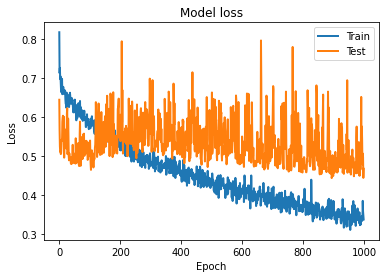

Confusion matrix, without normalization


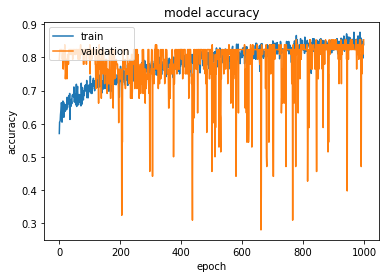

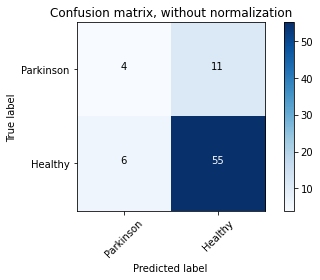

              precision    recall  f1-score   support

   Parkinson       0.40      0.27      0.32        15
     Healthy       0.83      0.90      0.87        61

   micro avg       0.78      0.78      0.78        76
   macro avg       0.62      0.58      0.59        76
weighted avg       0.75      0.78      0.76        76
 samples avg       0.78      0.78      0.78        76



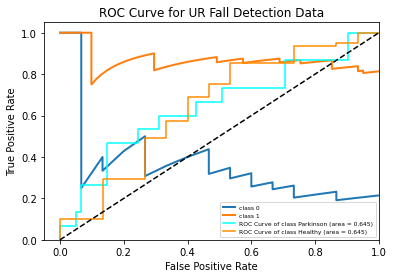

In [48]:
import tensorflow.compat.v1 as tf
from keras import backend as K
from keras.models import Model
from keras.callbacks import TensorBoard,ModelCheckpoint

import glob
import os

import cv2
from math import sin, cos, radians
import random
import numpy as np
from keras.models import Sequential,load_model,model_from_json


from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D,Cropping1D,Activation, Flatten, Dropout,BatchNormalization

from keras.utils.np_utils import to_categorical

from tensorflow.keras.optimizers import Adadelta, RMSprop, SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
from statistics import mean
import numpy as np, pandas as pd, io, csv

##compute_class_weight Modules
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder

#confusion_matrix Modules

from sklearn.metrics import confusion_matrix
## Precision/Recall/F1_score AND Roc curve Modules
from scipy import interp
import itertools    
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
###################################################################################################################

filename='/content/pd_speech_features.csv'


data2=pd.read_csv(filename, header = 1)

#Load TQWT DataSet
Fs1=data2.iloc[:,322:754]

#LOad Wavelet DataSet
Fs2=data2.iloc[:,140:322]

#LOad MFCC DataSet
Fs3=data2.iloc[:,56:140]

#Combination 2 or 3 DataSet
frames = [Fs1,Fs3,Fs2]
Fs = pd.concat(frames,axis=1)


#Load Lables
target=data2['class'].values

#Reshape and Split data to Train data and Test data
arrayofdata_ = np.array(Fs)

labels = np.array(target)

one_hot_labels = to_categorical(labels, num_classes=2)

x_train, x_test, y_train, y_test = train_test_split(arrayofdata_,
                                                          one_hot_labels,
                                                          test_size=0.1,shuffle=True,
                                                          random_state=42)


x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_train.shape[1],1))

#Reshape Data for Confusion_matrix
x_train1 = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test1 = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)

#Convolution1D network

def NetworkCNN():
    
    model = Sequential()
    model.add(Conv1D(128, 2, padding='same', activation='relu', input_shape=(x_train.shape[1],1)))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))
       
    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))
    

    model.add(Conv1D(32, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))

    model.add(Conv1D(16, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(16, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))


    model.add(Conv1D(8, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(8, 2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1, strides=2))

    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(2, activation='softmax'))

    
    model.compile(Adam(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

    # Compute Input weights
    from sklearn.utils import compute_class_weight

    y_integers = np.argmax(one_hot_labels, axis=1)
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_integers),
                                        y = y_integers                                                    
                                    )
    d_class_weights = dict(enumerate(class_weights))


    history = model.fit(x_train, y_train, 
                          
                        class_weight = d_class_weights,
                        batch_size =16,validation_split = 0.1,
                        validation_data=(x_test,y_test), verbose = 2, 
                        epochs = 1000)

   
    print('Accuracy')
    print(mean(history.history['accuracy']))
    print(mean(history.history['val_accuracy']))

   

    print('loss')
    print(mean(history.history['loss']))
    print(mean(history.history['val_loss']))


    #Model Loss Plot
    plt.plot(history.history['loss'], linewidth=2, label='Train')
    plt.plot(history.history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')    
    plt.show()

    #Model Accuracy Plot
        

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    return model

#################################################Confusion_matrix Code#########################################


Net=NetworkCNN()
Net = Net.predict(x_test)
classification=np.argmax(Net)
y_pred_2=Net.argmax(axis=-1)

class_names=["Parkinson","Healthy"]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

cnf_matrix = confusion_matrix(y_test1, y_pred_2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

#################################################Precision/Recall/F1_score AND Roc curve#########################################
n_classes=2
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        Net[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
    f_Score=2*((precision[i]*recall[i])/(precision[i]+recall[i]+K.epsilon()))
print(classification_report(y_test, Net.round(), target_names=class_names))


fpr = dict()
tpr = dict()
roc_auc = dict() 
# compute fpr and tpr with roc_curve from the ytest true labels to the scores
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Net[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot each class  curve on single graph for multi-class one vs all classification
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color, lbl in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UR Fall Detection Data')
plt.legend(loc = 'lower right', prop = {'size': 6})

plt.show()